#Setup

In [1]:
!pip install ucimlrepo

In [3]:
import time                          # measure training & prediction time (latency)
import numpy as np                   # numeric ops
import pandas as pd                  # table ops
import matplotlib.pyplot as plt      # all plots

from ucimlrepo import fetch_ucirepo  # official UCI loader for CTG

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    balanced_accuracy_score, f1_score
)
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance
import joblib                        # save/load trained models

# Show wide tables & avoid scientific notation so outputs are readable in judging
pd.set_option("display.max_columns", 200)
np.set_printoptions(suppress=True)

#Load Data

In [4]:
# Fetch dataset from UCI repository
cardiotocography = fetch_ucirepo(id=193)

# Data (as pandas DataFrames)
X = cardiotocography.data.features.copy()
y_all = cardiotocography.data.targets.copy()
y_nsp = y_all["NSP"].astype(int)    # 1=Normal, 2=Suspect, 3=Pathologic
y_cls = y_all["CLASS"].astype(int)  # 1..10

# Metadata & variable info help us describe the dataset in the presentation
print("\n=== Metadata ===")
print(cardiotocography.metadata)

print("\n=== Variables (features + targets) ===")
print(cardiotocography.variables)

# Basic hygiene checks (shape, missing values, class balance)
print("\nFeatures shape:", X.shape)
print("Missing values total:", X.isna().sum().sum() + y_nsp.isna().sum() + y_cls.isna().sum())
print("\nNSP class counts:\n", y_nsp.value_counts().sort_index())
print("\nCLASS class counts:\n", y_cls.value_counts().sort_index())



=== Metadata ===
{'uci_id': 193, 'name': 'Cardiotocography', 'repository_url': 'https://archive.ics.uci.edu/dataset/193/cardiotocography', 'data_url': 'https://archive.ics.uci.edu/static/public/193/data.csv', 'abstract': 'The dataset consists of measurements of fetal heart rate (FHR) and uterine contraction (UC) features on cardiotocograms classified by expert obstetricians.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 2126, 'num_features': 21, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['CLASS', 'NSP'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2000, 'last_updated': 'Fri Mar 15 2024', 'dataset_doi': '10.24432/C51S4N', 'creators': ['D. Campos', 'J. Bernardes'], 'intro_paper': None, 'additional_info': {'summary': '2126 fetal cardiotocograms (CTGs) were automatically processed and the respective diagnostic features measured. The CTGs we

#Explore Data with Histograms

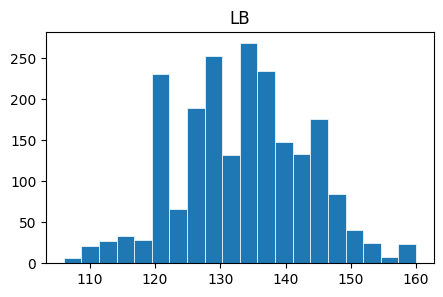

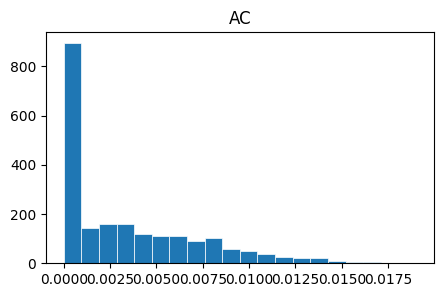

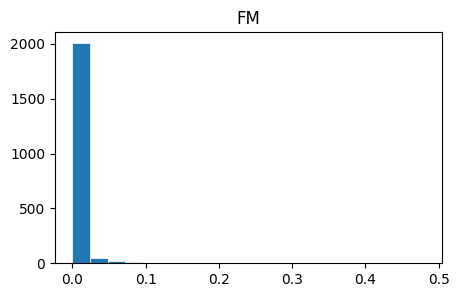

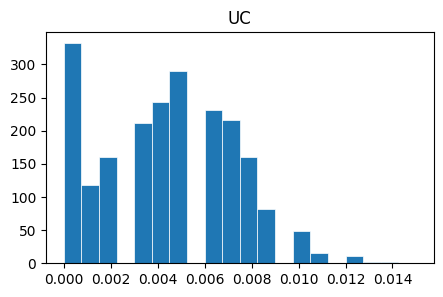

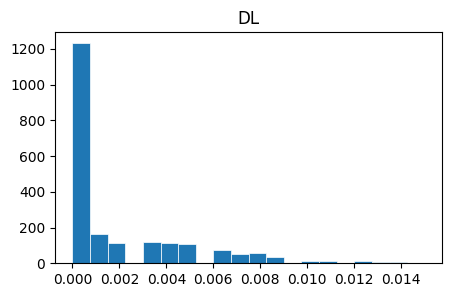

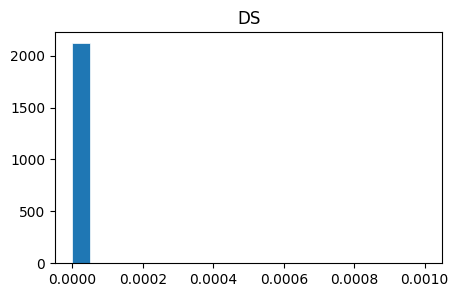

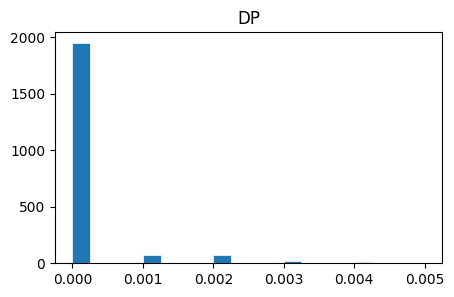

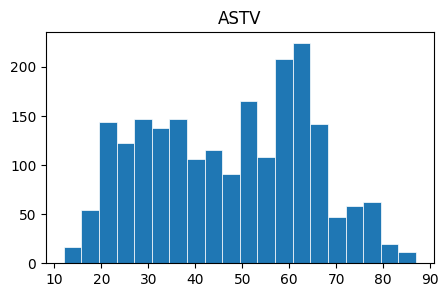

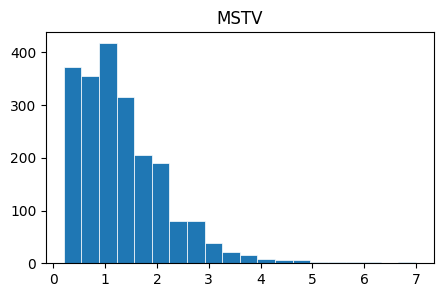

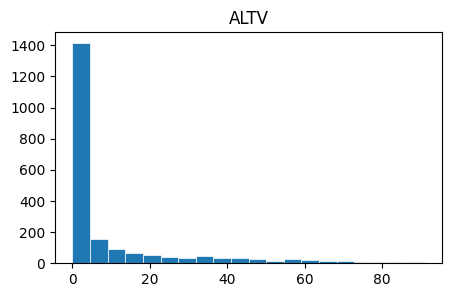

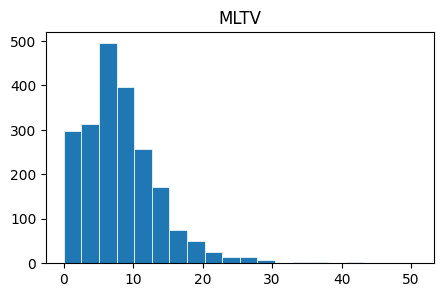

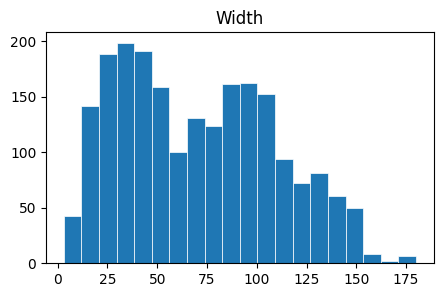

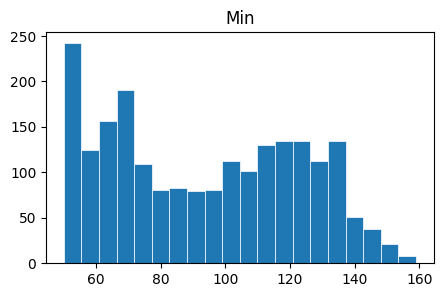

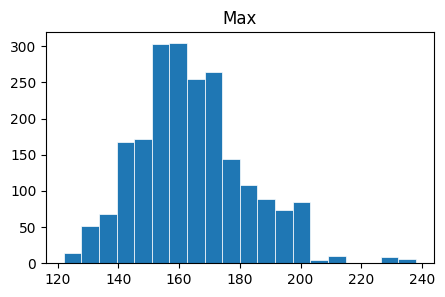

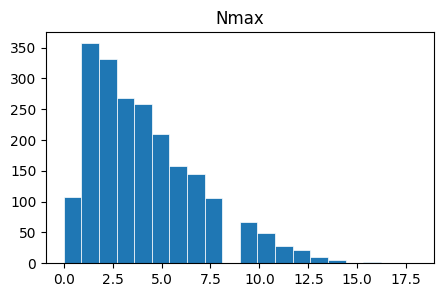

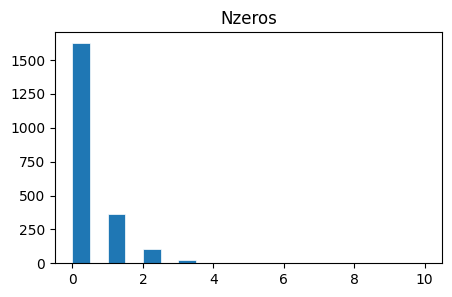

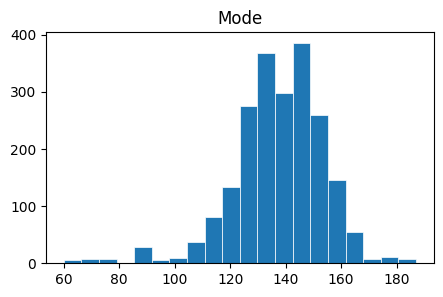

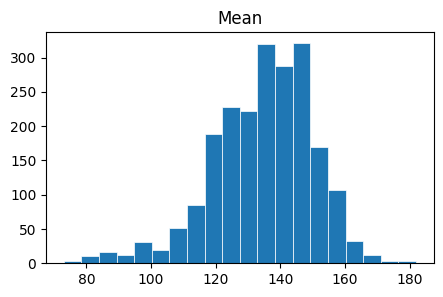

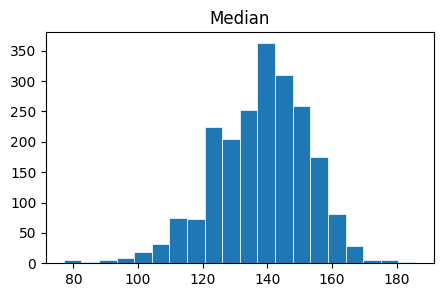

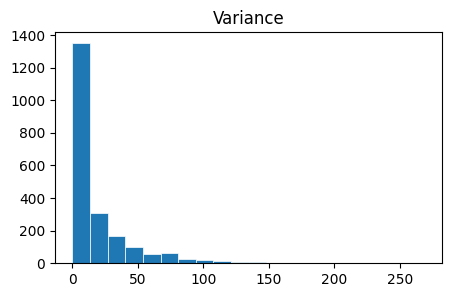

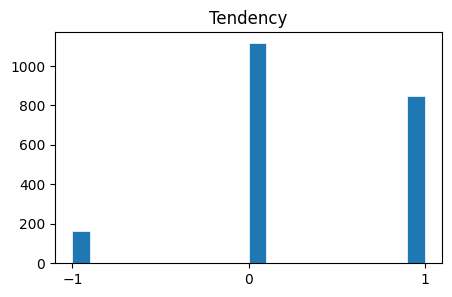

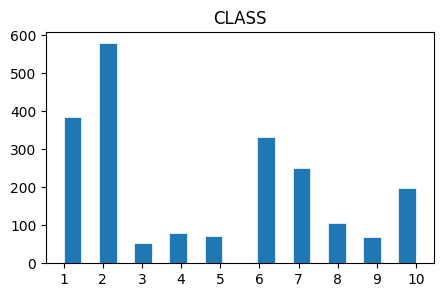

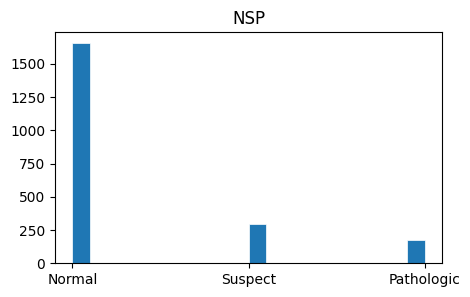

Min DS: 0.0
Max DS: 0.001


In [5]:
# Histograms for each variable (features + both targets)
columns = cardiotocography.variables['name']

for column in columns:
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 3)

    if column not in ['NSP', 'CLASS']:
        data = cardiotocography.data.features[column]
    else:
        data = cardiotocography.data.targets[column]

    ax.hist(data, bins=20, linewidth=0.5, edgecolor="white")

    # Friendly x-ticks for categorical targets / special variables
    if column == 'NSP':
        ax.set_xticks([1, 2, 3])
        ax.set_xticklabels(['Normal', 'Suspect', 'Pathologic'])
    elif column == 'CLASS':
        ax.set_xticks(np.arange(1, 11))
    elif column.upper() == 'TENDENCY':
        ax.set_xticks(np.arange(-1, 2))

    ax.set_title(column)
    plt.show()

# Range checks
print("Min DS:", cardiotocography.data.features['DS'].min())
print("Max DS:", cardiotocography.data.features['DS'].max())


#Feature–Target Relationships (Spearman correlation)




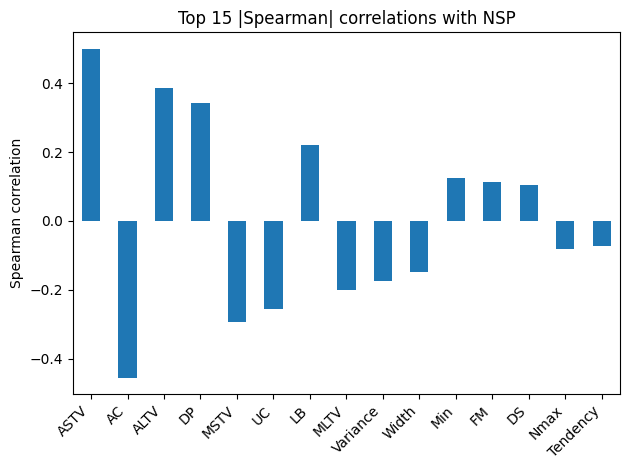

In [6]:
# Correlation of each feature vs NSP. Spearman is good for ordinal target (1<2<3)
spearman_vs_nsp = X.apply(lambda col: col.corr(y_nsp, method="spearman"))
spearman_sorted = spearman_vs_nsp.reindex(spearman_vs_nsp.abs().sort_values(ascending=False).index)

# keep figure readable
top_k = 15
spearman_sorted.head(top_k).plot(kind="bar")
plt.title(f"Top {top_k} |Spearman| correlations with NSP")
plt.ylabel("Spearman correlation")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()


#Train/Test Split

In [7]:
# 80/20 split with stratification so class proportions are preserved
Xtr_nsp, Xte_nsp, ytr_nsp, yte_nsp = train_test_split(X, y_nsp, test_size=0.2, stratify=y_nsp)
Xtr_cls, Xte_cls, ytr_cls, yte_cls = train_test_split(X, y_cls, test_size=0.2, stratify=y_cls)

print("NSP train/test:", Xtr_nsp.shape, Xte_nsp.shape)
print("CLASS train/test:", Xtr_cls.shape, Xte_cls.shape)

NSP train/test: (1700, 21) (426, 21)
CLASS train/test: (1700, 21) (426, 21)


#Evaluation Function

In [8]:
def evaluate_hgb(name, model, Xtr, ytr, Xte, yte, display_labels=None):
    # Latency
    t0 = time.perf_counter(); model.fit(Xtr, ytr); fit_s = time.perf_counter() - t0
    t1 = time.perf_counter(); ypred = model.predict(Xte); pred_ms = (time.perf_counter() - t1) * 1000

    # Imbalance-aware metrics
    ba  = balanced_accuracy_score(yte, ypred)
    f1m = f1_score(yte, ypred, average="macro")

    print(f"\n{name}")
    print(f"Balanced Accuracy: {ba:.4f} | Macro F1: {f1m:.4f} | fit={fit_s:.3f}s | predict={pred_ms:.1f}ms")
    print(classification_report(yte, ypred, target_names=display_labels) if display_labels else
          classification_report(yte, ypred))

    cm = confusion_matrix(yte, ypred)
    ConfusionMatrixDisplay(cm, display_labels=display_labels).plot(cmap="Blues")
    plt.title(f"{name} – Confusion Matrix"); plt.show()

    return {"ba":ba, "f1":f1m, "fit_s":fit_s, "pred_ms":pred_ms}, ypred, model


#Gradient Boosting NSP Model


HistGradientBoosting (NSP)
Balanced Accuracy: 0.9040 | Macro F1: 0.9060 | fit=1.502s | predict=16.3ms
              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98       332
     Suspect       0.86      0.85      0.85        59
  Pathologic       0.89      0.89      0.89        35

    accuracy                           0.95       426
   macro avg       0.91      0.90      0.91       426
weighted avg       0.95      0.95      0.95       426



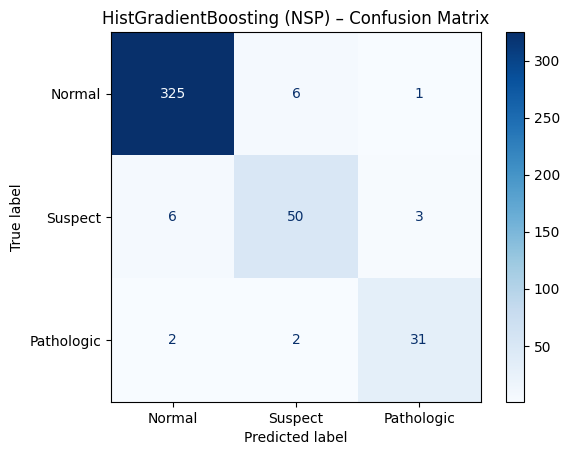

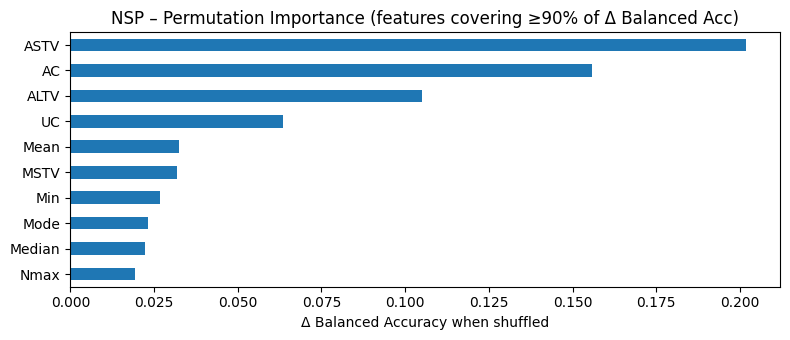

In [17]:
# HGB works well on tabular data.
hgb_nsp = HistGradientBoostingClassifier()

nsp_metrics, nsp_pred, nsp_fit = evaluate_hgb(
    "HistGradientBoosting (NSP)", hgb_nsp,
    Xtr_nsp, ytr_nsp, Xte_nsp, yte_nsp,
    display_labels=["Normal","Suspect","Pathologic"]
)

# Permutation importance
perm = permutation_importance(nsp_fit, Xte_nsp, yte_nsp, n_repeats=5, scoring="balanced_accuracy", n_jobs=-1)
perm_s = pd.Series(perm.importances_mean, index=X.columns).clip(lower=0).sort_values(ascending=False)

# FEWEST features that explain ≥90% of the total importance contribution
total = perm_s.sum() if perm_s.sum() > 0 else 1.0
cum = (perm_s / total).cumsum()
keep = perm_s.loc[cum <= 0.90]
if keep.empty: keep = perm_s.head(1)

keep.sort_values().plot(kind="barh", figsize=(8, max(3, 0.35*len(keep))))
plt.title("NSP – Permutation Importance (features covering ≥90% of Δ Balanced Acc)")
plt.xlabel("Δ Balanced Accuracy when shuffled")
plt.tight_layout(); plt.show()


#Gradient Boosting CLASS Model


HistGradientBoosting (CLASS 10-class)
Balanced Accuracy: 0.8476 | Macro F1: 0.8729 | fit=4.084s | predict=40.5ms
              precision    recall  f1-score   support

           1       0.88      0.91      0.89        77
           2       0.86      0.91      0.88       116
           3       0.91      0.91      0.91        11
           4       1.00      0.62      0.77        16
           5       0.80      0.57      0.67        14
           6       0.90      0.91      0.90        67
           7       0.91      0.96      0.93        51
           8       0.95      0.90      0.93        21
           9       1.00      0.86      0.92        14
          10       0.92      0.92      0.92        39

    accuracy                           0.89       426
   macro avg       0.91      0.85      0.87       426
weighted avg       0.89      0.89      0.89       426



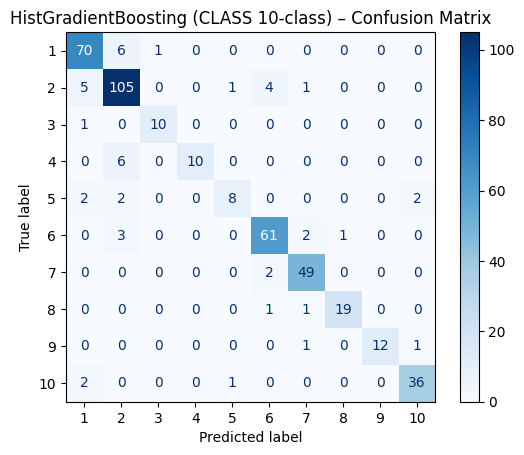

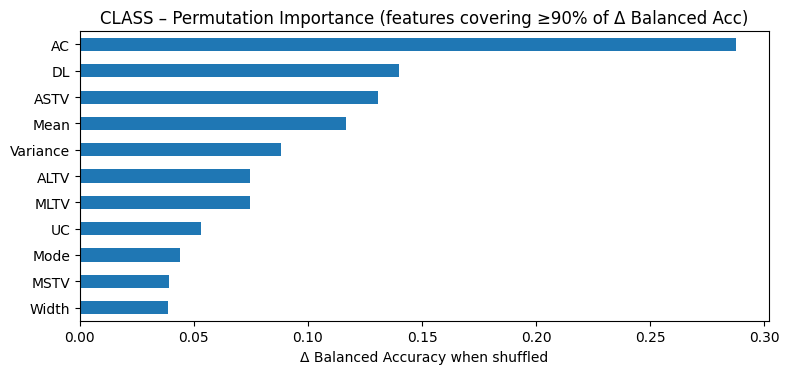

In [18]:
hgb_cls = HistGradientBoostingClassifier()

labels_cls = [str(i) for i in sorted(y_cls.unique())]
cls_metrics, cls_pred, cls_fit = evaluate_hgb(
    "HistGradientBoosting (CLASS 10-class)", hgb_cls,
    Xtr_cls, ytr_cls, Xte_cls, yte_cls,
    display_labels=labels_cls
)

# Permutation importance
permC = permutation_importance(cls_fit, Xte_cls, yte_cls, n_repeats=5, scoring="balanced_accuracy", n_jobs=-1)
permC_s = pd.Series(permC.importances_mean, index=X.columns).clip(lower=0).sort_values(ascending=False)

totalC = permC_s.sum() if permC_s.sum() > 0 else 1.0
cumC = (permC_s / totalC).cumsum()
keepC = permC_s.loc[cumC <= 0.90]
if keepC.empty: keepC = permC_s.head(1)

keepC.sort_values().plot(kind="barh", figsize=(8, max(3, 0.35*len(keepC))))
plt.title("CLASS – Permutation Importance (features covering ≥90% of Δ Balanced Acc)")
plt.xlabel("Δ Balanced Accuracy when shuffled")
plt.tight_layout(); plt.show()


#Cross-Validation Between Folds

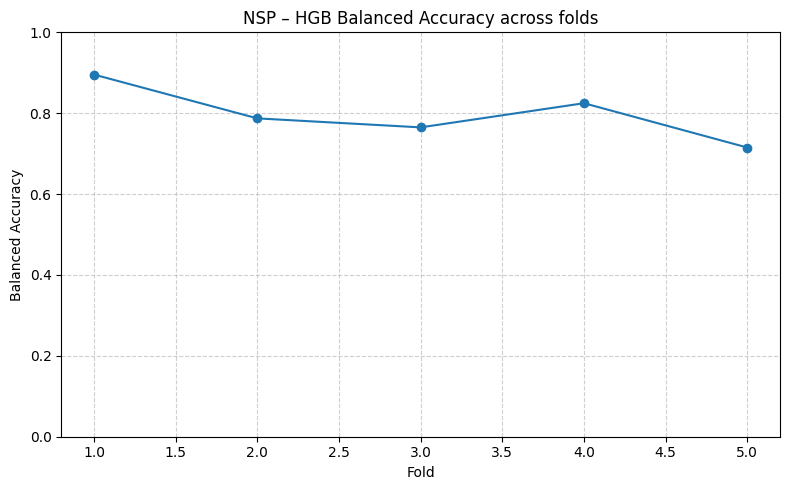

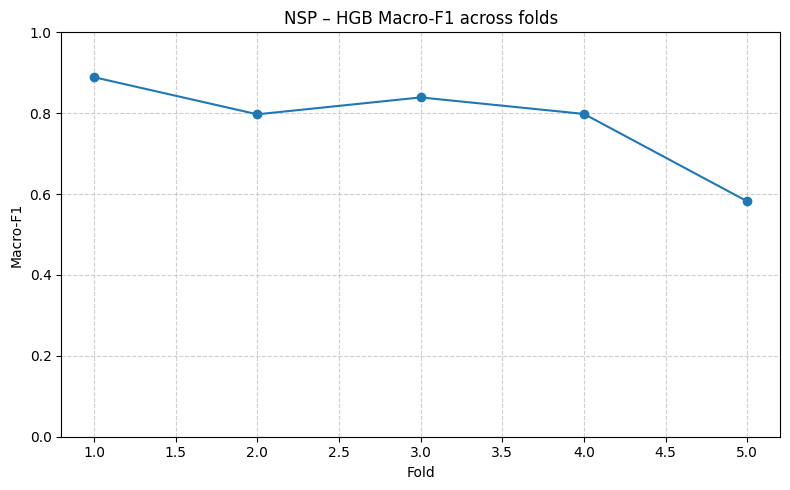

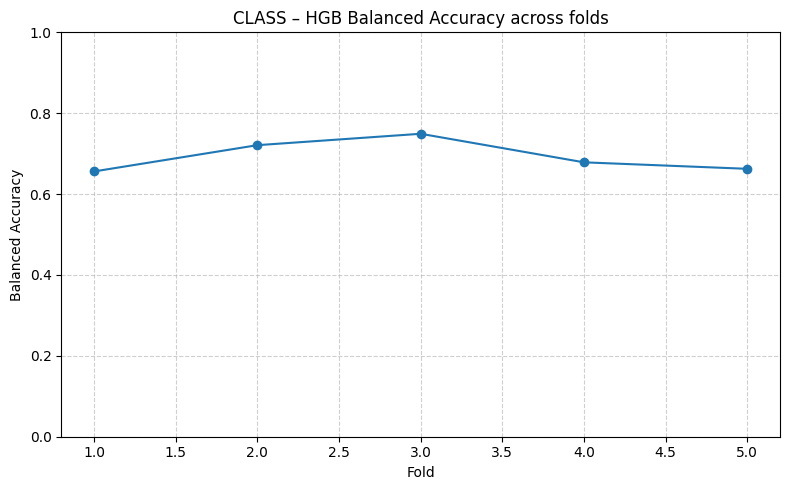

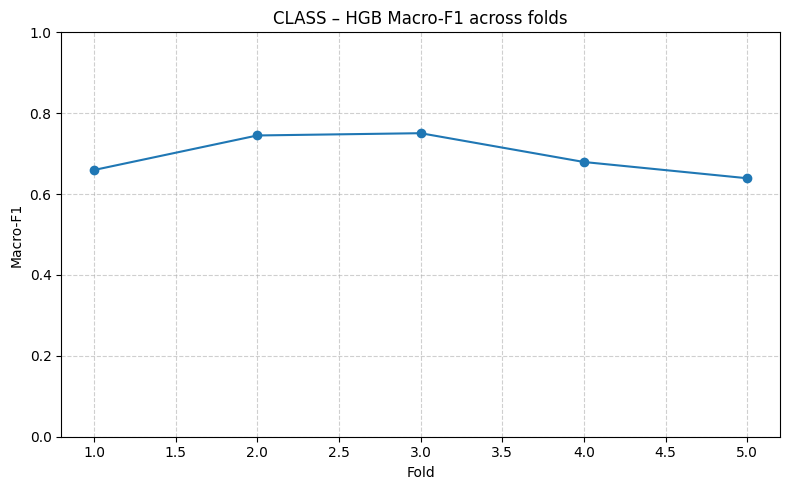

In [11]:
cv = StratifiedKFold(n_splits=5)

# NSP per-fold scores
ba_nsp = cross_val_score(HistGradientBoostingClassifier(), X, y_nsp, scoring="balanced_accuracy", cv=cv, n_jobs=-1)
f1_nsp = cross_val_score(HistGradientBoostingClassifier(), X, y_nsp, scoring="f1_macro",          cv=cv, n_jobs=-1)

# CLASS per-fold scores
ba_cls = cross_val_score(HistGradientBoostingClassifier(), X, y_cls, scoring="balanced_accuracy", cv=cv, n_jobs=-1)
f1_cls = cross_val_score(HistGradientBoostingClassifier(), X, y_cls, scoring="f1_macro",          cv=cv, n_jobs=-1)

# Line plots
plt.figure(figsize=(8,5))
plt.plot(range(1, len(ba_nsp)+1), ba_nsp, marker="o")
plt.ylim(0,1); plt.grid(True, ls="--", alpha=0.6)
plt.title("NSP – HGB Balanced Accuracy across folds")
plt.xlabel("Fold"); plt.ylabel("Balanced Accuracy")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(1, len(f1_nsp)+1), f1_nsp, marker="o")
plt.ylim(0,1); plt.grid(True, ls="--", alpha=0.6)
plt.title("NSP – HGB Macro-F1 across folds")
plt.xlabel("Fold"); plt.ylabel("Macro-F1")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(1, len(ba_cls)+1), ba_cls, marker="o")
plt.ylim(0,1); plt.grid(True, ls="--", alpha=0.6)
plt.title("CLASS – HGB Balanced Accuracy across folds")
plt.xlabel("Fold"); plt.ylabel("Balanced Accuracy")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(1, len(f1_cls)+1), f1_cls, marker="o")
plt.ylim(0,1); plt.grid(True, ls="--", alpha=0.6)
plt.title("CLASS – HGB Macro-F1 across folds")
plt.xlabel("Fold"); plt.ylabel("Macro-F1")
plt.tight_layout(); plt.show()


#Bars for the test-set metrics

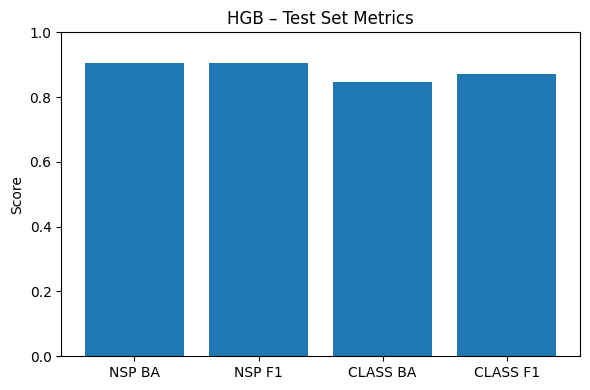

In [12]:
# Bar chart (one model, two metrics)
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(["NSP BA","NSP F1","CLASS BA","CLASS F1"],
       [nsp_metrics["ba"], nsp_metrics["f1"], cls_metrics["ba"], cls_metrics["f1"]])
ax.set_ylim(0,1); ax.set_ylabel("Score"); ax.set_title("HGB – Test Set Metrics")
plt.tight_layout(); plt.show()


#Save Models & Predict Functions

In [13]:
# Save both trained HGB models so we can load without retraining
joblib.dump(hgb_nsp, "HGB_NSP.pkl")
joblib.dump(hgb_cls, "HGB_CLASS.pkl")

# Save test predictions for auditability
pd.DataFrame({"y_test": yte_nsp.values, "y_pred": nsp_pred}).to_csv("HGB_NSP_test_preds.csv", index=False)
pd.DataFrame({"y_test": yte_cls.values, "y_pred": cls_pred}).to_csv("HGB_CLASS_test_preds.csv", index=False)
print("Saved: HGB_NSP.pkl, HGB_CLASS.pkl, and test prediction CSVs.")

# Predict functions for live demo
def predict_nsp(new_df):
    model = joblib.load("HGB_NSP.pkl")
    preds = model.predict(new_df[X.columns])   # ensure same columns/order
    return pd.Series(preds).map({1:"Normal", 2:"Suspect", 3:"Pathologic"})

def predict_class(new_df):
    model = joblib.load("HGB_CLASS.pkl")
    preds = model.predict(new_df[X.columns])
    return pd.Series(preds)                    # 1..10 labels

# Mini demo
# NSP demo: show predictions vs true labels
print("\nNSP Demo (first 5 test samples):")
nsp_demo_preds = predict_nsp(Xte_nsp.head(5))      # model predictions
nsp_demo_truth = yte_nsp.head(5).map({1:"Normal", 2:"Suspect", 3:"Pathologic"})  # true labels
nsp_demo = pd.DataFrame({"True Label": nsp_demo_truth.values,
                         "Predicted Label": nsp_demo_preds.values})
print(nsp_demo)

# CLASS demo: show predictions vs true labels
print("\nCLASS Demo (first 5 test samples):")
cls_demo_preds = predict_class(Xte_cls.head(5))    # model predictions
cls_demo_truth = yte_cls.head(5)                   # true labels (1..10)
cls_demo = pd.DataFrame({"True Label": cls_demo_truth.values,
                         "Predicted Label": cls_demo_preds.values})
print(cls_demo)


Saved: HGB_NSP.pkl, HGB_CLASS.pkl, and test prediction CSVs.

NSP Demo (first 5 test samples):
  True Label Predicted Label
0     Normal          Normal
1     Normal          Normal
2     Normal          Normal
3     Normal          Normal
4    Suspect         Suspect

CLASS Demo (first 5 test samples):
   True Label  Predicted Label
0           1                1
1           1                1
2          10                5
3           2                2
4           2                2
